In [1]:
from commonfunctions import *
from Preprocessor import Preprocessor
from Model import *

## Training the model

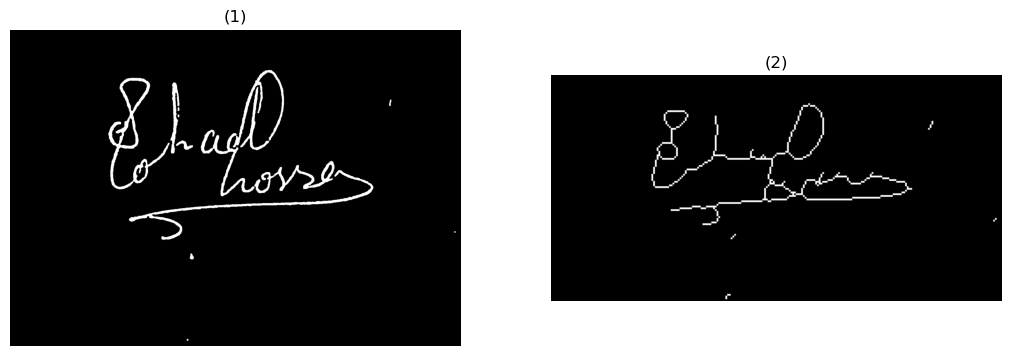

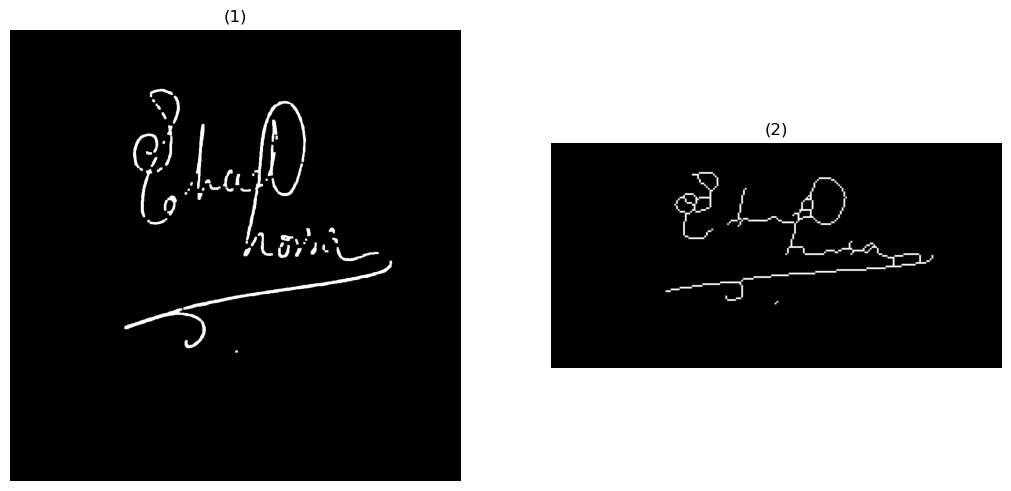

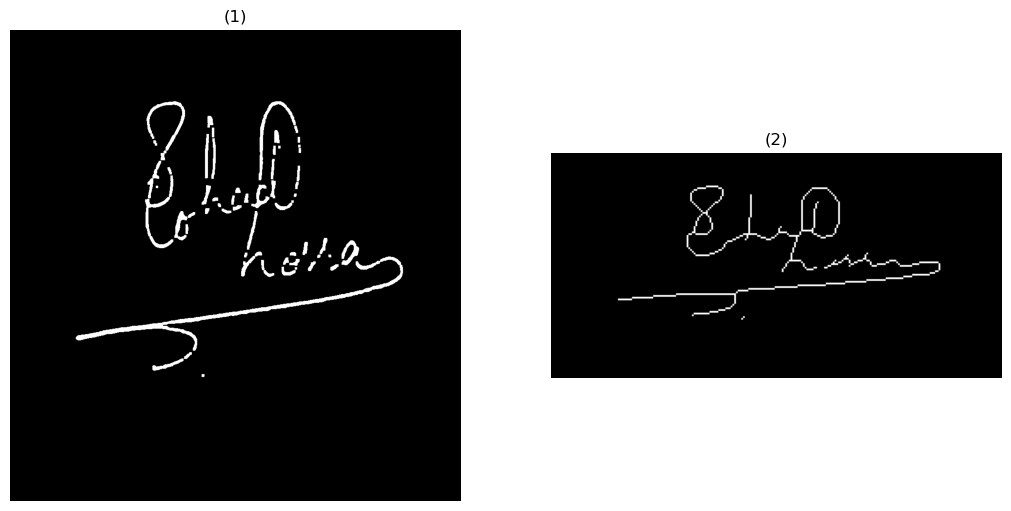

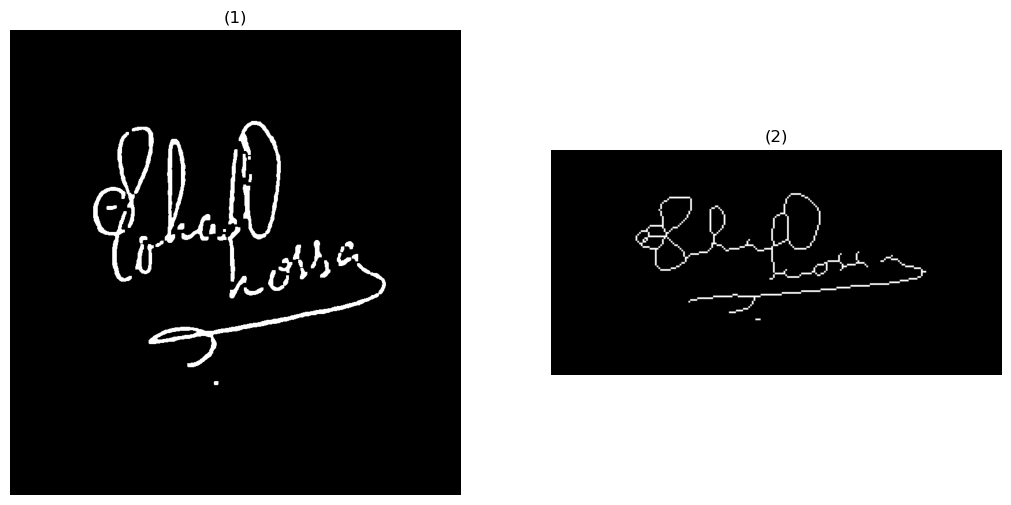

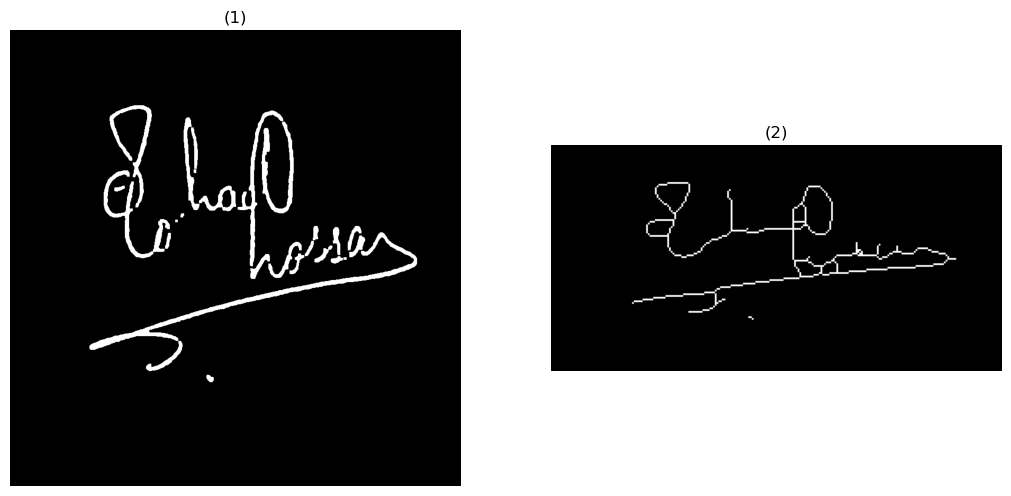

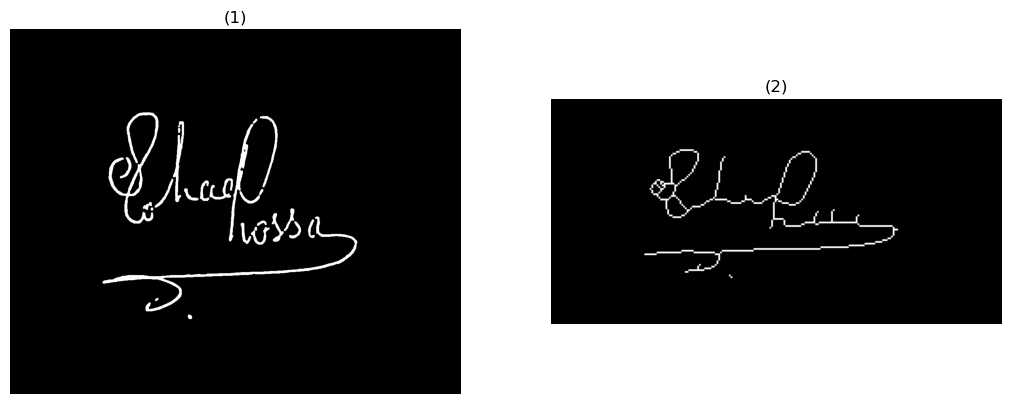

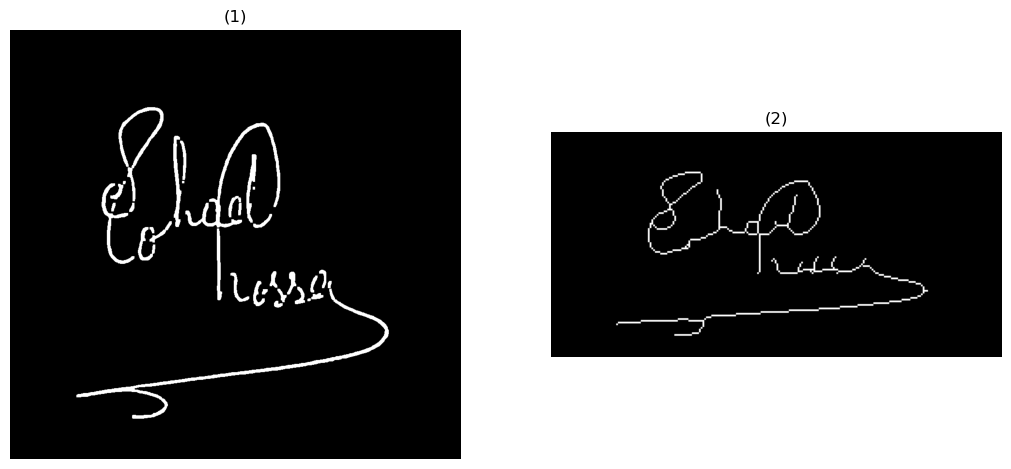

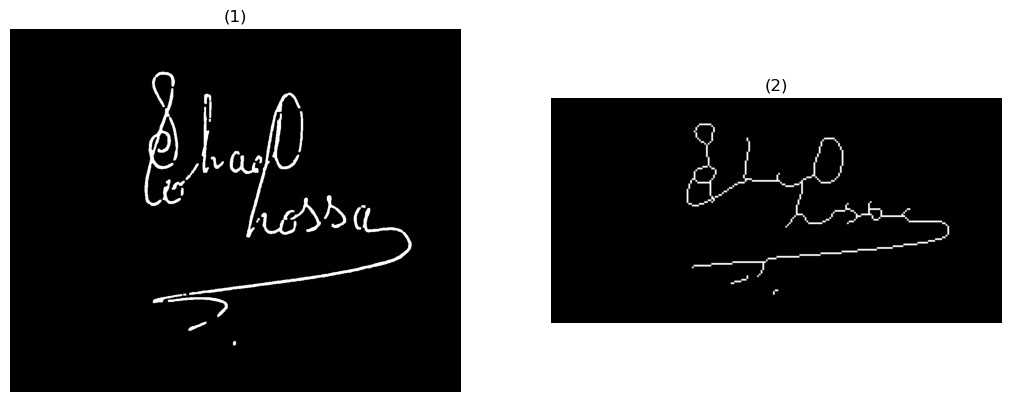

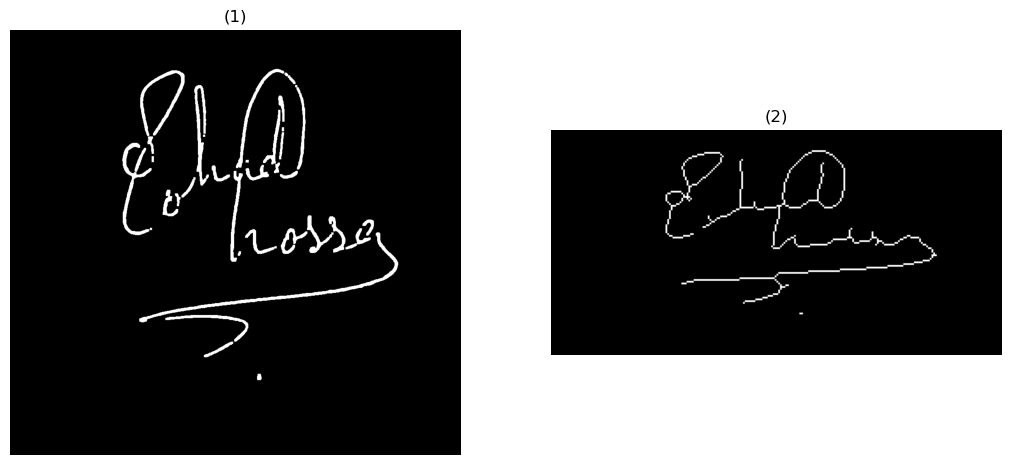

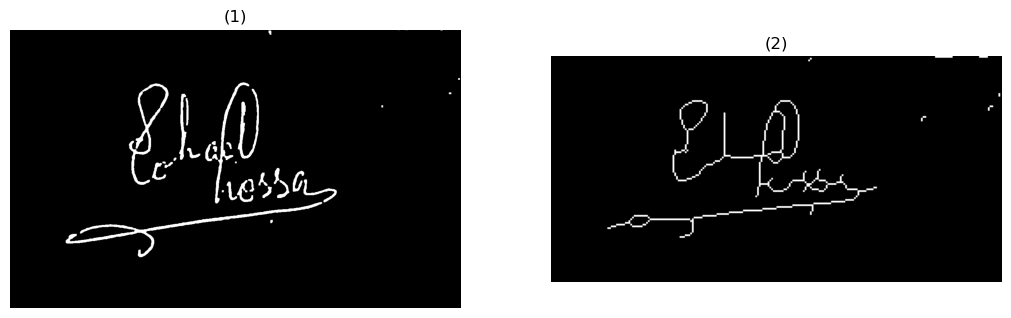

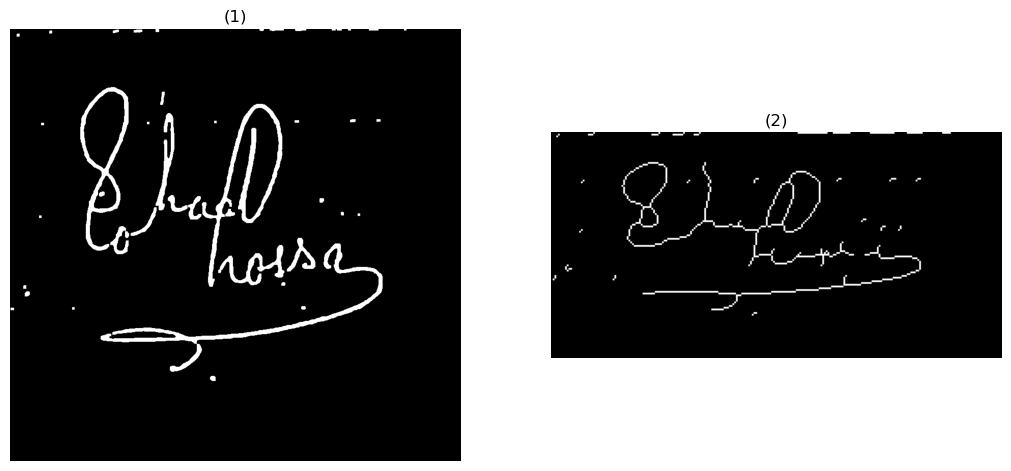

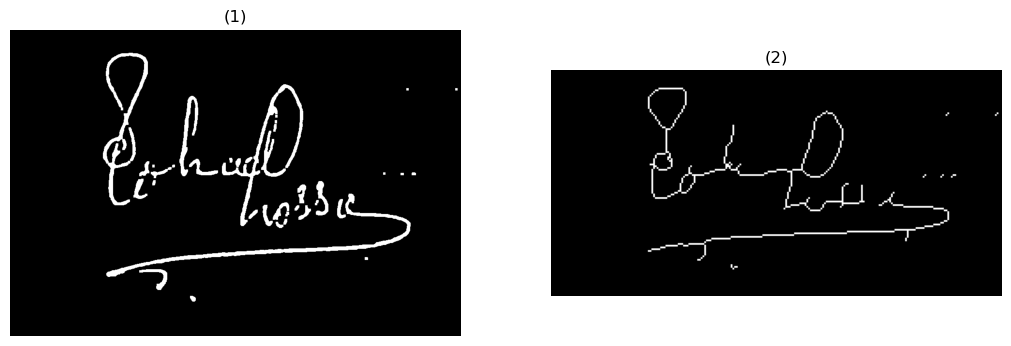

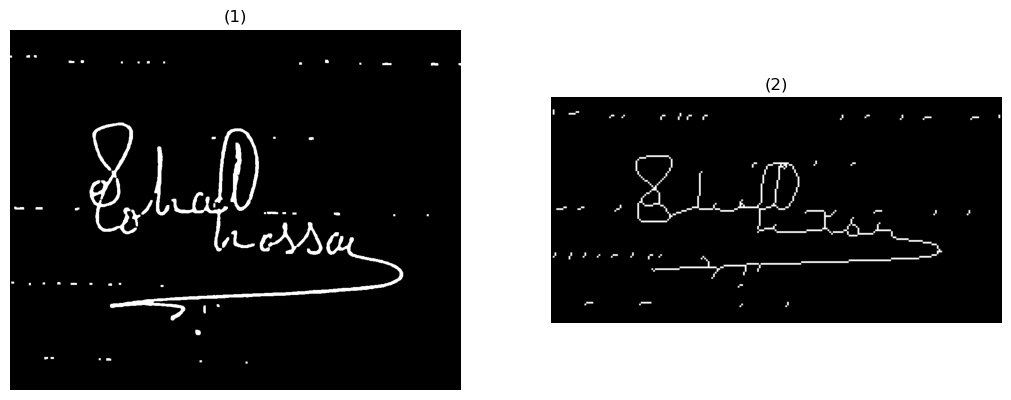

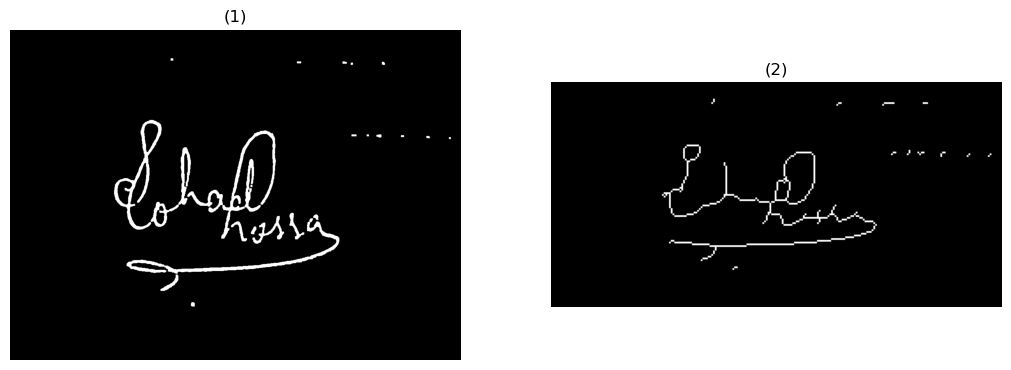

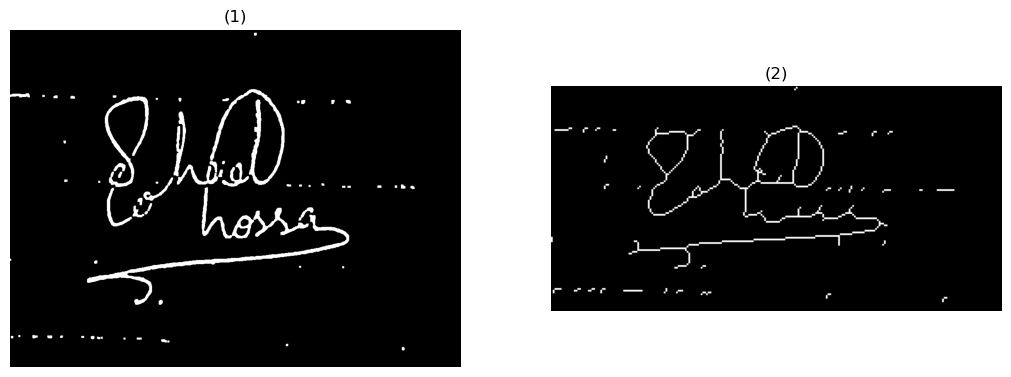

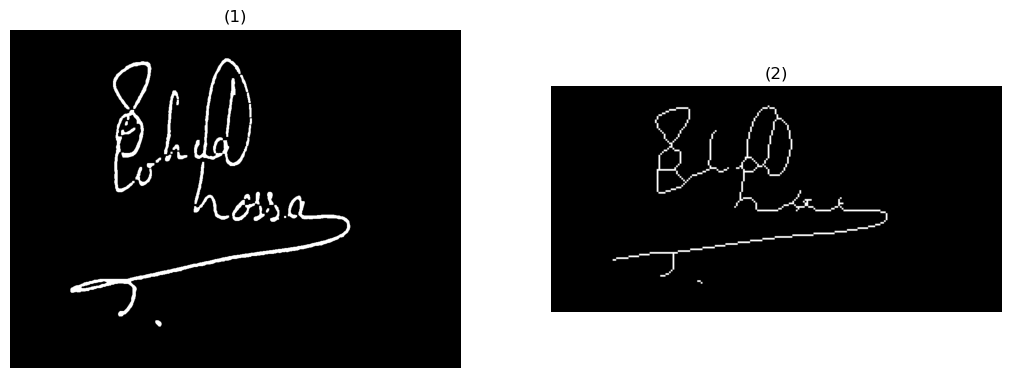

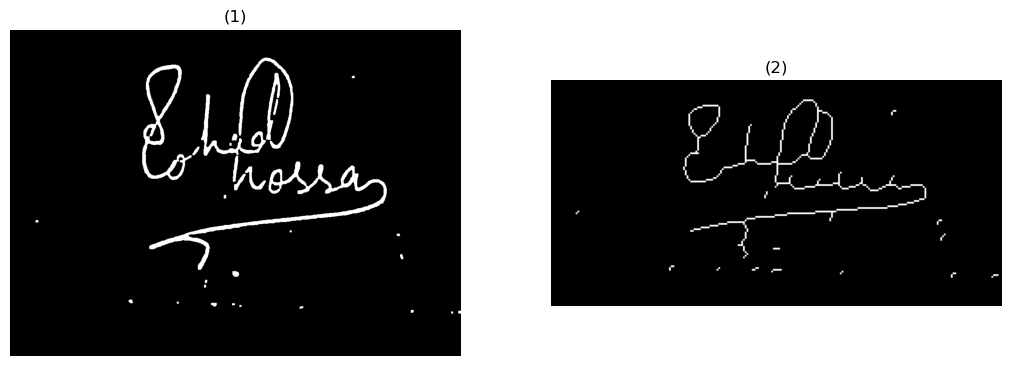

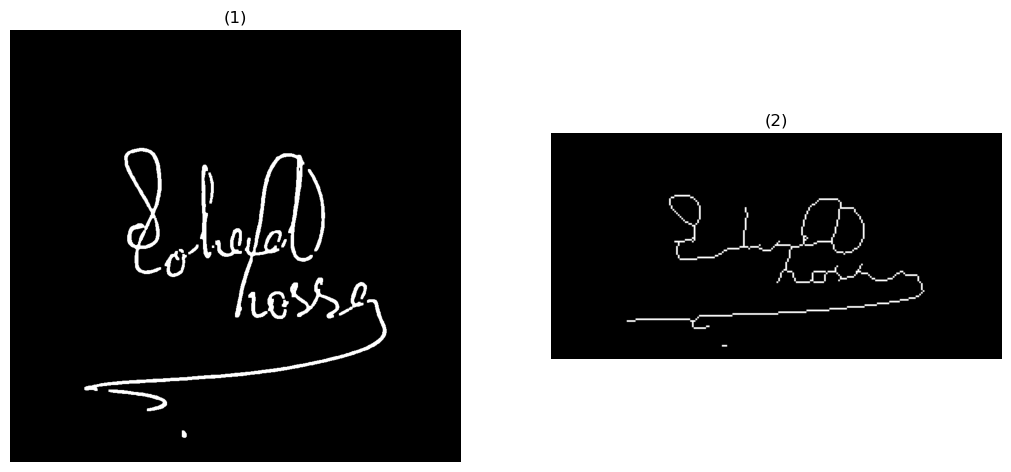

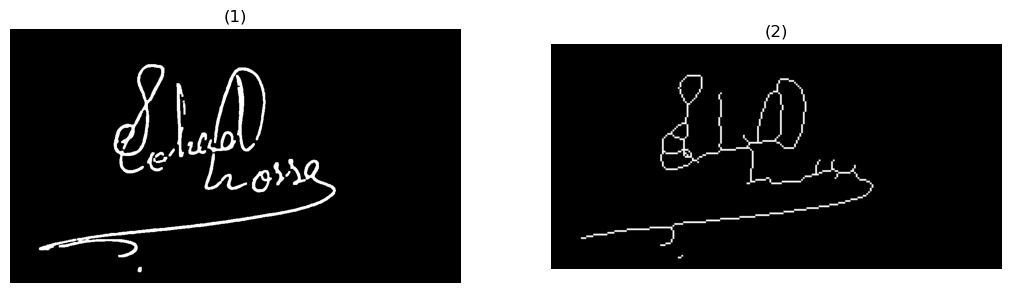

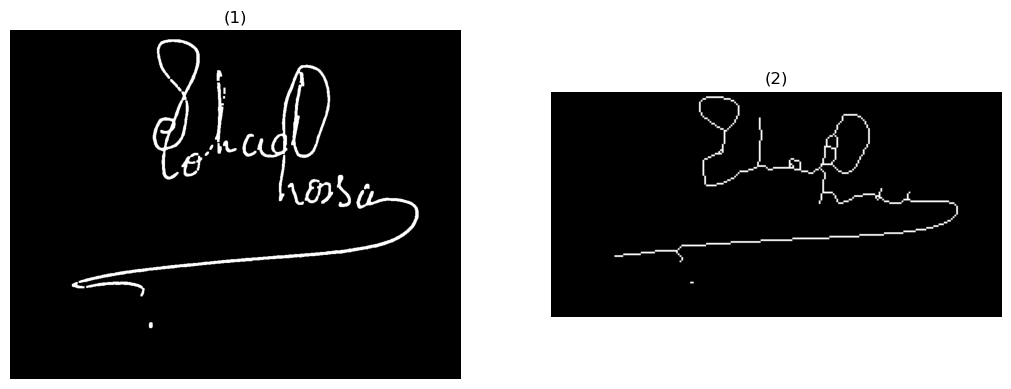

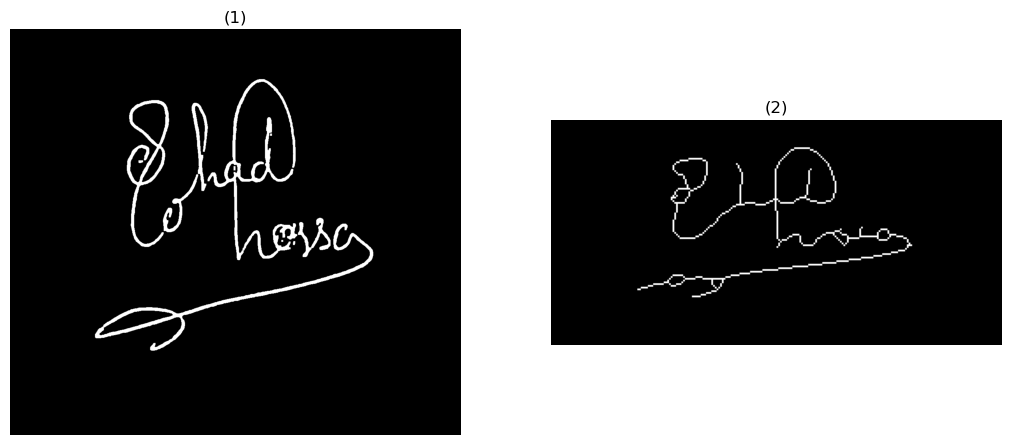

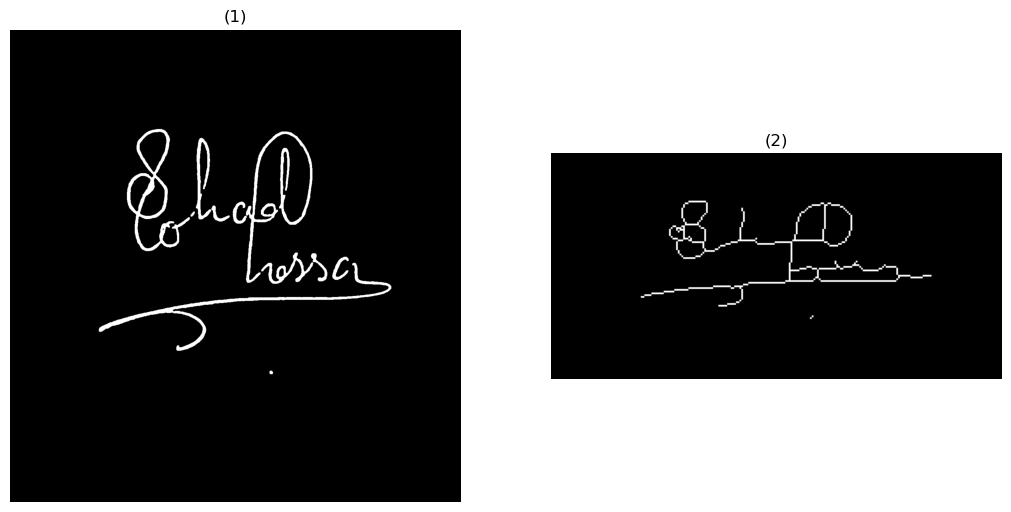

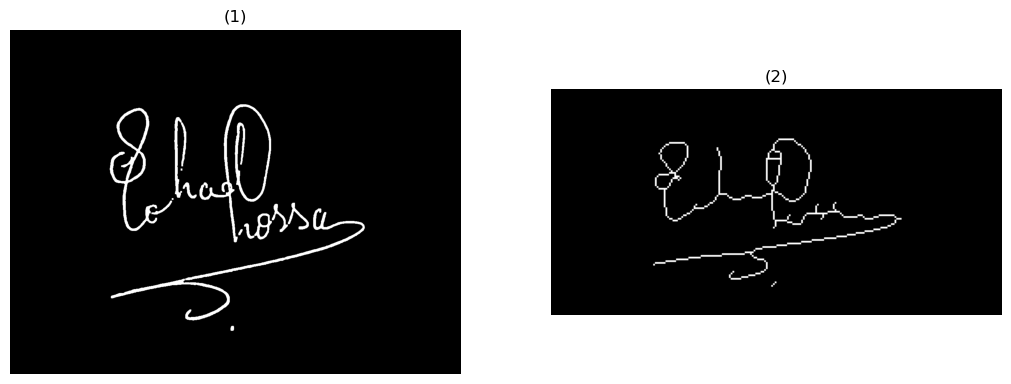

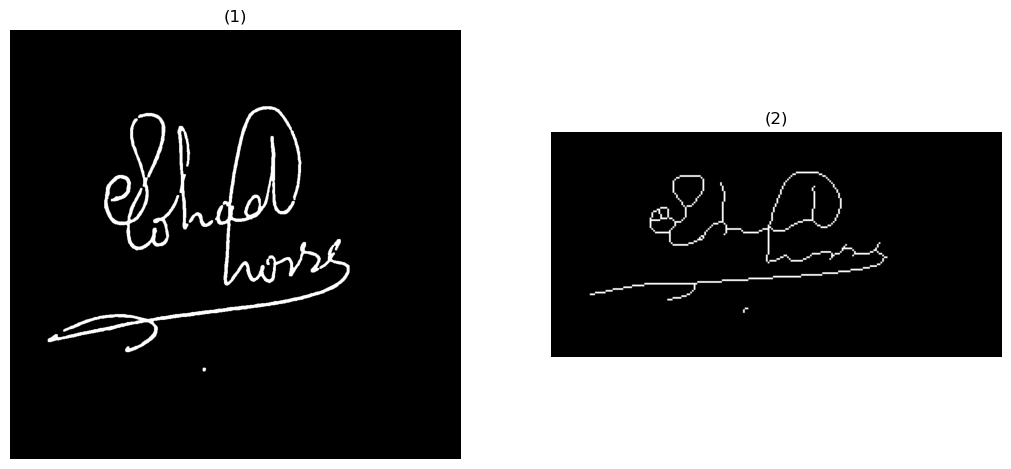

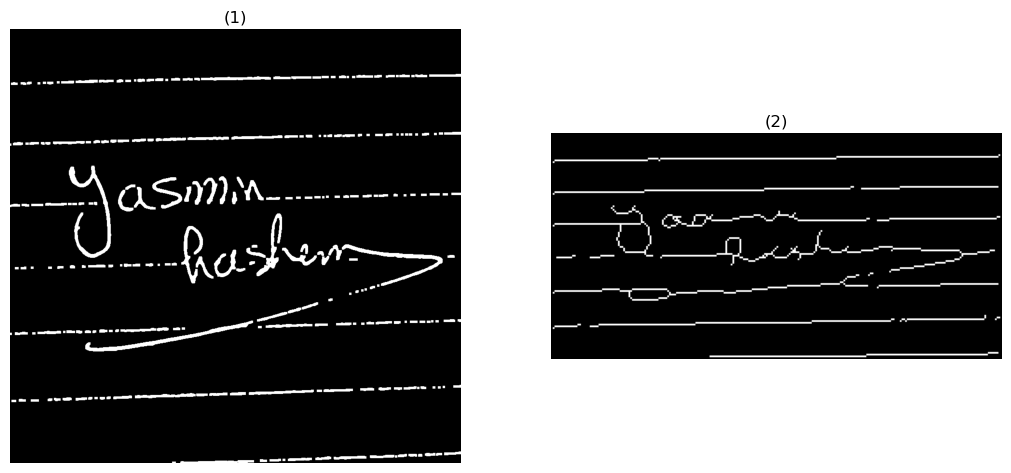

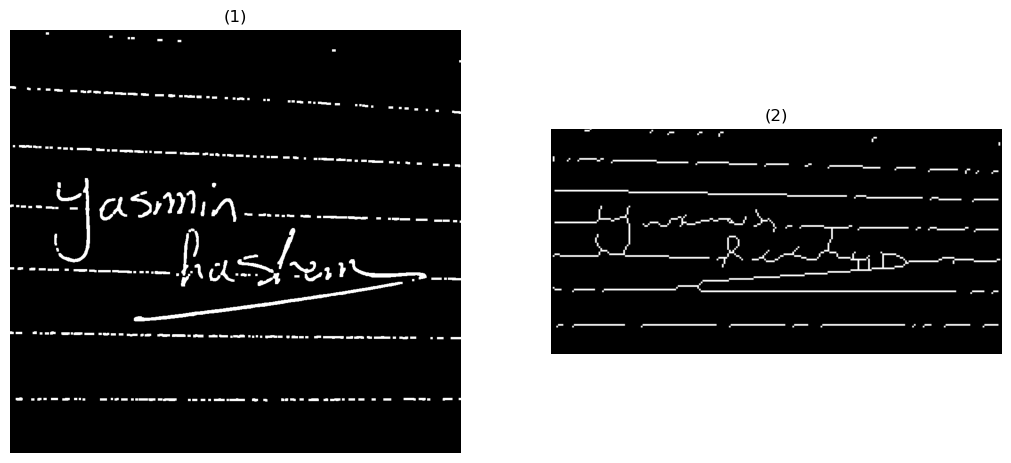

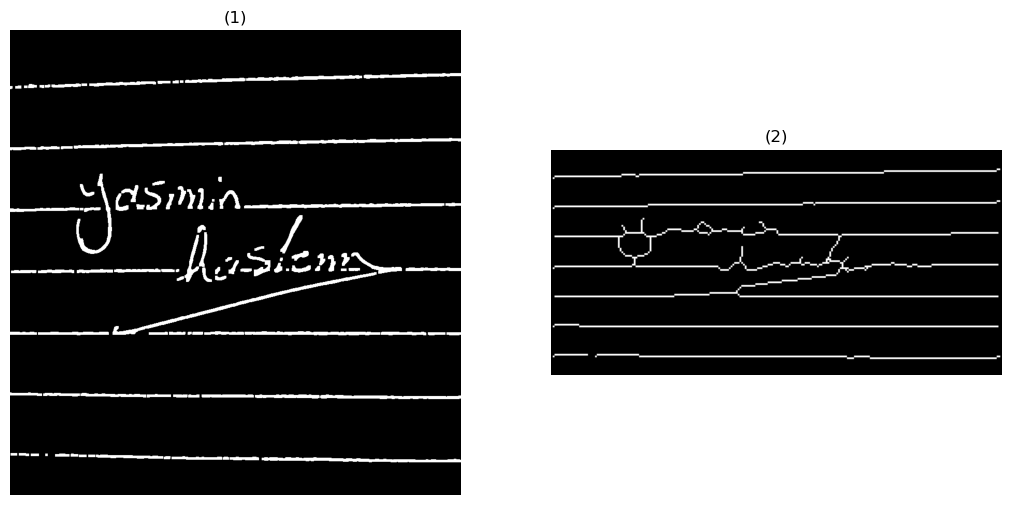

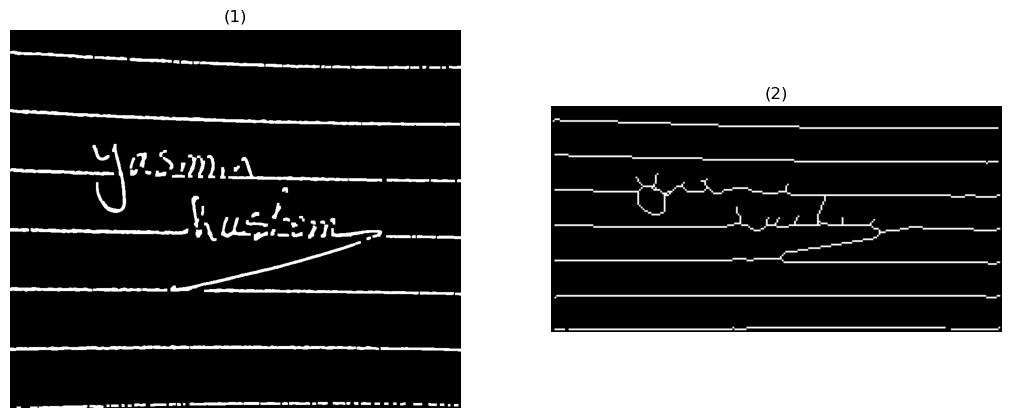

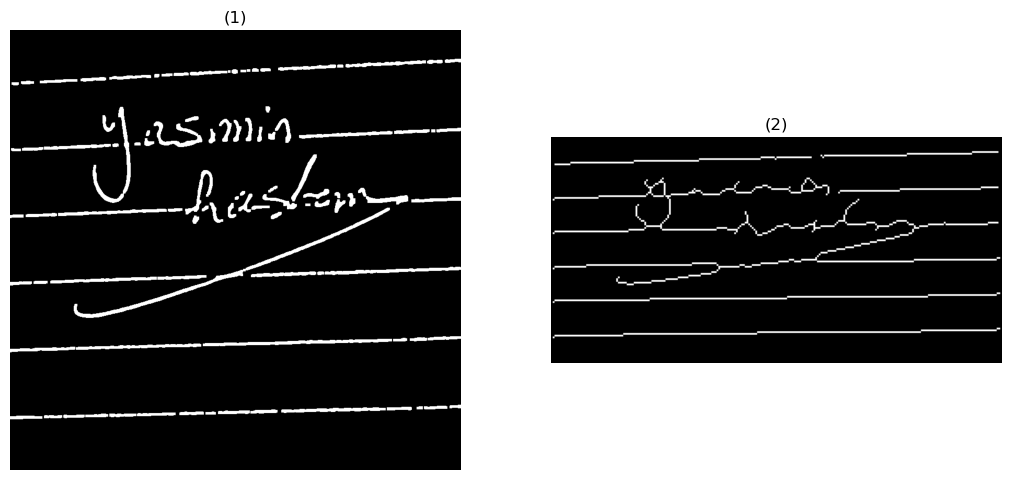

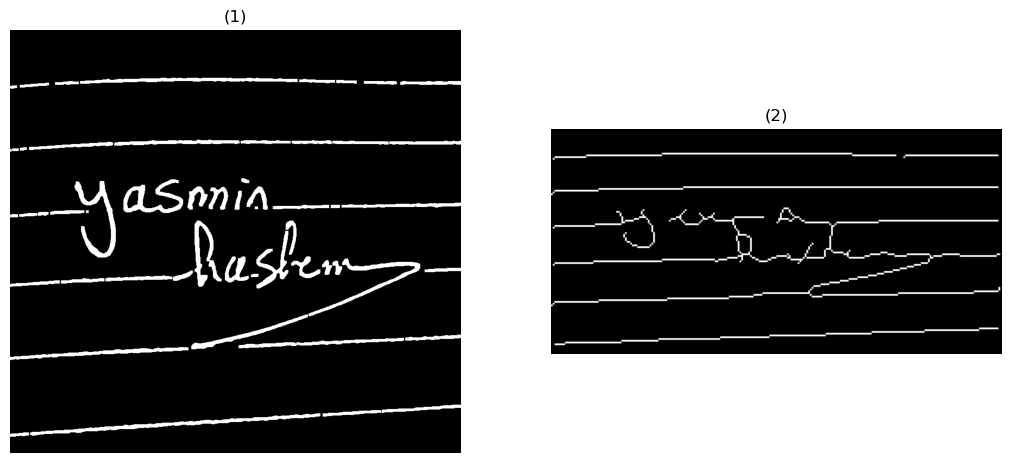

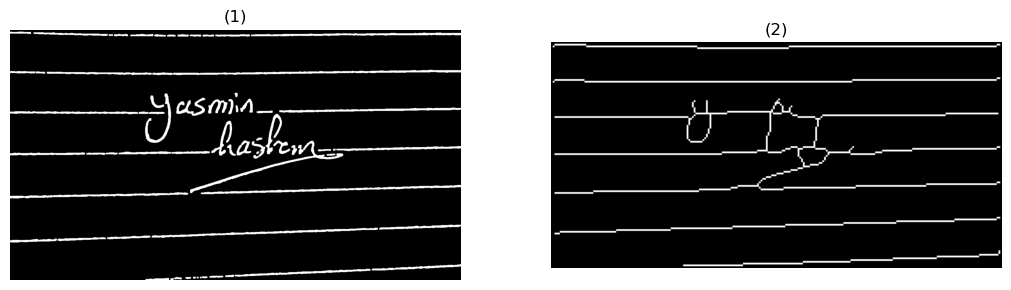

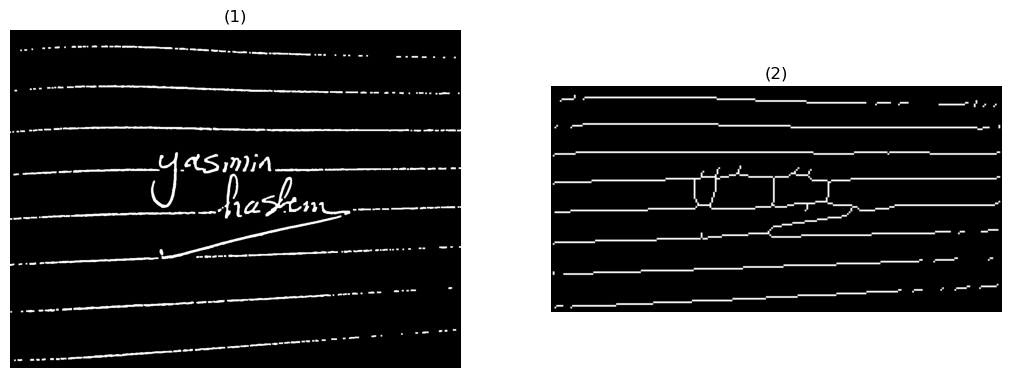

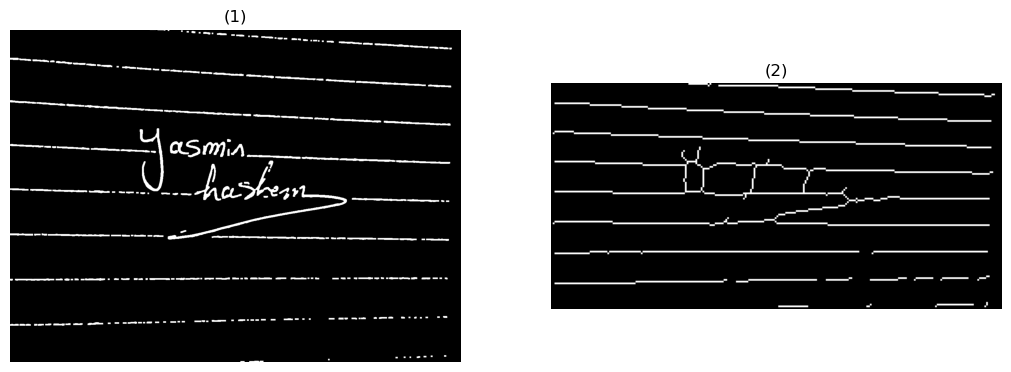

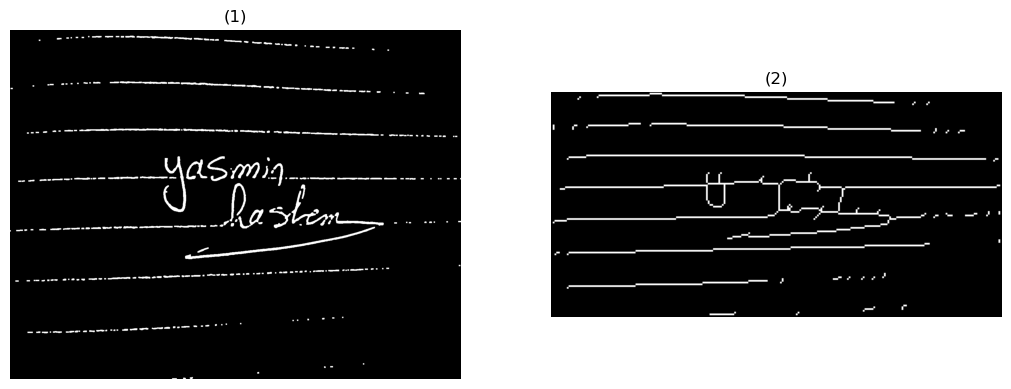

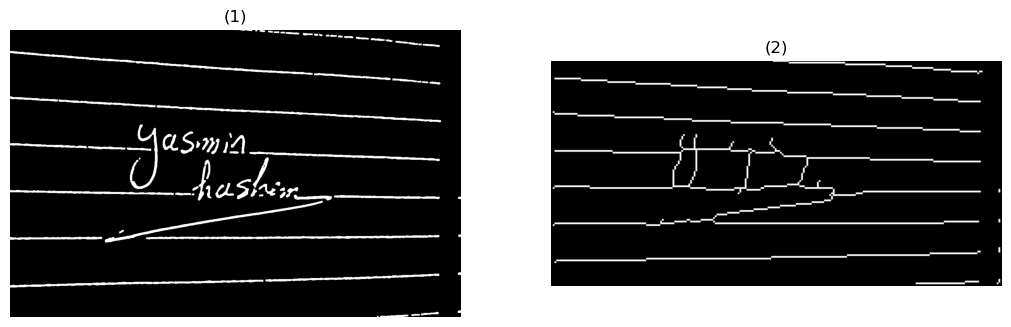

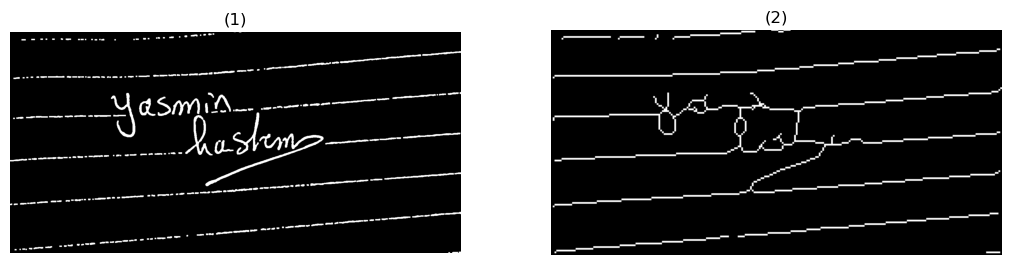

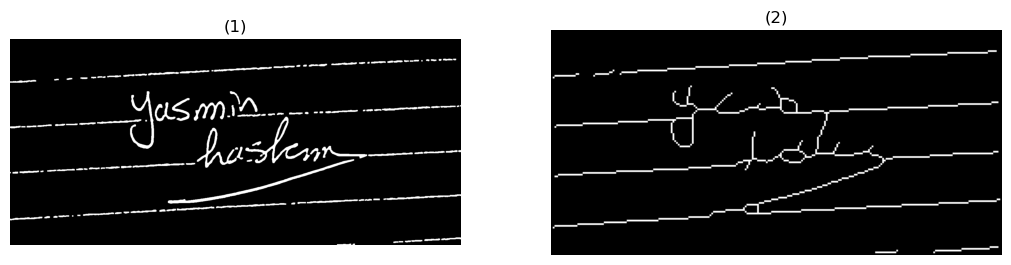

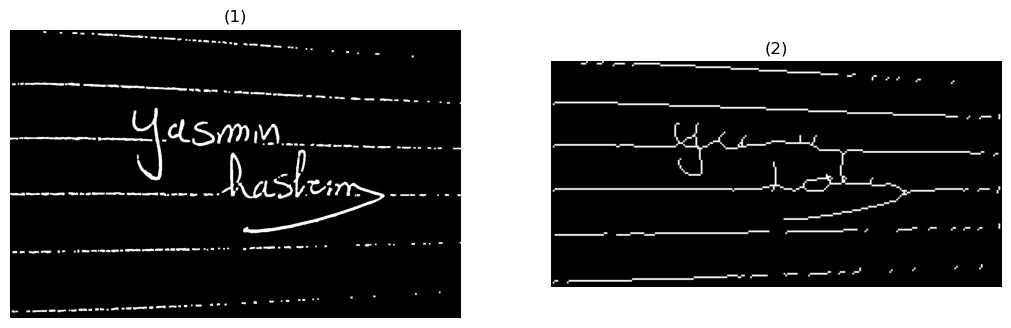

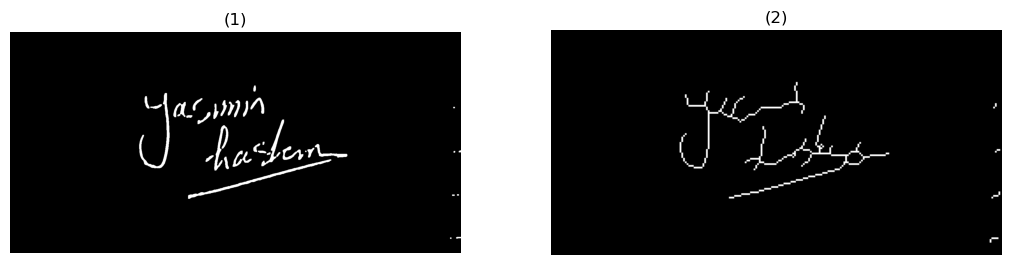

In [2]:
model = Model()
model.train(real_dir='all/real/', forged_dir='all/forged/')
model.loadModel()

## Model Prediction

In [ ]:
model.predict(1, 'testImgs/')

In [ ]:
real_imgs = readDataset('all/real/')
forged_imgs = readDataset('all/forged/')
test_imgs = readDataset('testImgs/')

In [ ]:
real_extracted_features = extractFeatures(real_imgs)
forged_extracted_features = extractFeatures(forged_imgs)
test_extraced_features = extractFeatures(test_imgs)

In [ ]:
HOG_features = forged_extracted_features + real_extracted_features
HOG_labels_forged = [0 for _ in range(len(forged_extracted_features))]
HOG_labels_real = [1 for _ in range(len(real_extracted_features))]
HOG_labels = HOG_labels_forged + HOG_labels_real
test_imgs_label = 1

x_train, x_test, y_train, y_test = train_test_split(HOG_features, HOG_labels, test_size = 0.2, random_state = 42)
model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)

accuracy = model.score(x_test, y_test)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')
accuracy = model.score(x_train, y_train)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')

dump(model, 'model.pkl')